- - -

#### _Extracting lineage metrics from PhysiCell output for informed ABM development._

- - -

_Citations:_

elmar bucher, godzilla-but-nicer, Randy Heiland, Paul Macklin, & Patrick G Wall. (2023). elmbeech/physicelldataloader: 2023-07-23 (v3.2.9). Zenodo. https://doi.org/10.5281/zenodo.8176400

Ghaffarizadeh, A., Heiland, R., Friedman, S. H., Mumenthaler, S. M., & Macklin, P. (2018). PhysiCell: An open source physics-based cell simulator for 3-D multicellular systems. PLoS computational biology, 14(2), e1005991.

Ghaffarizadeh, A., Friedman, S. H., & Macklin, P. (2016). BioFVM: an efficient, parallelized diffusive transport solver for 3-D biological simulations. Bioinformatics, 32(8), 1256-1258.

- - -

# Install libraries

In [36]:
# for loading PhysiCell output
## !pip3 install -U pcdl[all]

# for data visualization
## !pip3 install plotly==5.22.0
## !pip3 install pygraphviz

# for HTML output
## !pip install jinja2==3.0.3
## !pip install nbconvert==6.4.4
## !pip install pretty-jupyter 

%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


# Load libraries

In [2]:
import pcdl

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import json

import ipykernel # for debugging
from IPython.display import display, HTML

from scipy.spatial import KDTree

import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "notebook"


import networkx as nx

import collections

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Load data

Output is in `../../output_ffdd1e6s_small` and `../../output_ffdd1e6s_large`.

In [22]:
# -.-|m { output: false }

output_path_small = "../../output_ffdd1e6_small"
output_path_large = "../../output_ffdd1e6_large"

# MultiCellular Data Standard // https://www.biorxiv.org/content/10.1101/090456v2

# TimeSeries -- the entirety of the simulation
mcds_ts_small = pcdl.TimeSeries(output_path_small) 
all_mcds_small = mcds_ts_small.read_mcds()

mcds_ts_large = pcdl.TimeSeries(output_path_large) 
all_mcds_large = mcds_ts_large.read_mcds()

# TimeStep -- a "snapshot" of the simulation
# mcds = pcdl.TimeStep(file_48_path)

reading: ../../output_ffdd1e6_small/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['cycling_contact_halfmax', 'cycling_entry_threshold_resource', 'cycling_pressure_halfmax', 'damage_halfmax', 'debris_sensitivity', 'differentiation_contact_halfmax', 'inflammation_sensitivity', 'migration_bias_halfmax', 'migration_speed_halfmax', 'necrosis_saturation_resource', 'necrosis_threshold_resource', 'quorum_sensitivity', 'relative_max_damage_death', 'relative_max_toxicity', 'secretion_halfmax', 'toxicity_halfmax']
reading: ../../output_ffdd1e6_small/output00000000.xml
working on metadata ...
working on mesh data ...
reading: ../../output_ffdd1e6_small/initial_mesh0.mat
working on microenvironment data ...
reading: ../../output_ffdd1e6_small/output00000000_microenvironment0.mat
parsing: resource data
parsing: toxin data
parsing: quorum data
parsing: pro-inflammatory data
parsing: debris data
working on discrete cell data ..

In [24]:
mcds_25_small = all_mcds_small[25]
mcds_25_large = all_mcds_large[25]

print(mcds_25_small.get_time(), mcds_25_large.get_time())

4500.0 4500.0


# Prepare data

In [25]:
# variables that have only 1 state carry no information, 
# so output variables with at least 2 states

df_cell_small = mcds_25_small.get_cell_df(states=2)

df_cell_large = mcds_25_large.get_cell_df(states=2)

In [26]:
display(df_cell_small)

,cell_count_voxel,cell_density_micron3,cytoplasmic_volume,debris,debris_internalized_total_substrates,debris_net_export_rates,elapsed_time_in_phase,fluid_fraction,generation,mesh_center_m,...,runtime,surface_area,time,total_volume,toxin,toxin_internalized_total_substrates,tree_ID,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
0,2,0.000250,29.822472,0.092168,-1.592995e+06,500.000000,1734.0,0.998587,0.0,-190.0,...,3.450099,183.632364,4500.0,233.990191,2.073308e-143,-130801.0,0.0,10,39,0
1,3,0.000375,30.791320,0.120391,-1.877995e+06,500.000000,2304.0,0.998355,0.0,70.0,...,3.450099,133.704166,4500.0,145.375500,2.020103e-143,-73801.0,1.0,23,17,0
2,2,0.000250,29.894302,0.102472,-2.159995e+06,500.000000,2868.0,0.997702,0.0,30.0,...,3.450099,97.704368,4500.0,90.812322,2.025336e-143,-17401.0,2.0,21,18,0
3,2,0.000250,30.609245,0.050169,-2.006995e+06,500.000000,2562.0,0.998110,0.0,390.0,...,3.450099,115.827280,4500.0,117.216864,1.999541e-143,-48001.0,3.0,39,14,0
4,2,0.000250,30.076489,0.050169,-2.129995e+06,500.000000,2808.0,0.997793,0.0,390.0,...,3.450099,101.018393,4500.0,95.471665,1.999541e-143,-23401.0,4.0,39,14,0
5,1,0.000125,29.855443,0.040363,-2.165995e+06,500.000000,2880.0,0.997684,0.0,-110.0,...,3.450099,97.054767,4500.0,89.908163,2.065514e-143,-16201.0,5.0,14,34,0
6,2,0.000250,30.353090,0.113215,-2.075995e+06,500.000000,2700.0,0.997943,0.0,50.0,...,3.450099,107.270427,4500.0,104.470537,2.021590e-143,-34201.0,6.0,22,17,0
7,3,0.000375,30.127190,0.125640,-2.120995e+06,500.000000,2790.0,0.997819,0.0,70.0,...,3.450099,102.034421,4500.0,96.915640,2.022336e-143,-25201.0,7.0,23,18,0
8,1,0.000125,30.774728,0.041099,-1.919995e+06,500.000000,2388.0,0.998285,0.0,-290.0,...,3.450099,127.599023,4500.0,135.532932,2.019659e-143,-65401.0,8.0,5,0,0


In [27]:
display(df_cell_large)

,cell_count_voxel,cell_density_micron3,current_cycle_phase_exit_rate,current_death_model,current_phase,cycle_model,cytoplasmic_biomass_change_rate,cytoplasmic_volume,dead,death_rates_1,...,target_solid_nuclear,time,total_volume,toxin,toxin_internalized_total_substrates,toxin_net_export_rates,tree_ID,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
0,4,0.000500,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,14.480321,True,0.0028,...,0.00,4500.0,27.723549,8.503798e-134,-4800.5,0.0,0.1,8,39,0
1,3,0.000375,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,30.006043,True,0.0028,...,0.00,4500.0,93.579846,8.715488e-134,-21001.0,0.0,1.0,22,24,0
2,2,0.000250,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,29.627394,True,0.0028,...,0.00,4500.0,85.094159,8.766797e-134,-9601.0,0.0,2.0,23,16,0
3,3,0.000375,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,30.542921,True,0.0028,...,0.00,4500.0,113.180767,8.893761e-134,-43801.0,0.0,3.0,35,14,0
4,2,0.000250,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,30.093593,True,0.0028,...,0.00,4500.0,95.950579,8.898110e-134,-24001.0,0.0,4.0,35,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1,0.000125,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,15.091559,True,0.0028,...,0.00,4500.0,28.676993,8.488620e-134,-6600.5,0.0,419.1,3,30,0
420,1,0.000125,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,17.787667,True,0.0028,...,0.00,4500.0,35.795157,8.613559e-134,-13200.5,0.0,420.1,9,10,0
421,3,0.000375,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,29.630693,True,0.0028,...,0.00,4500.0,127.678331,8.724871e-134,-67200.5,0.0,421.1,17,4,0


In [81]:
df_cell_small = df_cell_small.astype({"generation": int})
small = df_cell_small[["generation", "tree_ID", "parent_ID"]].sort_index()
display(small)


,generation,tree_ID,parent_ID
ID,,,
0,0,0.0,-1.0
1,0,1.0,-1.0
2,0,2.0,-1.0
3,0,3.0,-1.0
4,0,4.0,-1.0
5,0,5.0,-1.0
6,0,6.0,-1.0
7,0,7.0,-1.0
8,0,8.0,-1.0


In [62]:
df_cell_large = df_cell_large.astype({"generation": int})
large = df_cell_large[["generation", "tree_ID", "parent_ID"]].sort_index()
# display(large)

print(large["tree_ID"].unique())

large.to_csv('out.csv')

[1.000e-01 1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00
 7.000e+00 8.000e+00 9.000e+00 1.100e+01 1.210e+01 1.400e+01 1.500e+01
 1.610e+01 1.700e+01 1.800e+01 1.900e+01 2.010e+01 2.100e+01 2.200e+01
 2.510e+01 2.610e+01 2.700e+01 2.800e+01 2.900e+01 3.000e+01 3.100e+01
 3.200e+01 3.300e+01 3.400e+01 3.510e+01 3.710e+01 3.800e+01 3.910e+01
 4.100e+01 4.200e+01 4.400e+01 4.510e+01 4.610e+01 4.700e+01 4.800e+01
 4.900e+01 5.000e+01 5.100e+01 5.210e+01 5.300e+01 5.400e+01 5.500e+01
 5.610e+01 5.710e+01 5.810e+01 5.900e+01 6.100e+01 6.200e+01 6.300e+01
 6.500e+01 6.610e+01 6.710e+01 6.800e+01 6.900e+01 7.000e+01 7.100e+01
 7.200e+01 7.300e+01 7.410e+01 7.510e+01 7.600e+01 7.700e+01 7.800e+01
 7.900e+01 8.000e+01 8.100e+01 8.200e+01 8.400e+01 8.510e+01 8.610e+01
 8.710e+01 8.900e+01 9.010e+01 9.110e+01 9.200e+01 9.300e+01 9.410e+01
 9.500e+01 9.600e+01 9.700e+01 9.800e+01 9.910e+01 1.000e+02 1.010e+02
 1.020e+02 1.040e+02 1.050e+02 1.060e+02 1.070e+02 1.080e+02 1.090e+02
 1.100

In [82]:
ad = []

for timestep in all_mcds_large:
    time = timestep.data['metadata']['current_time']
    df = timestep.get_cell_df()
    df = df.loc[(df['parent_ID'] >= 10.0) & (df['parent_ID'] <= 20.0)]
    df['time'] = time
    ad.append(df)

cells_16_lineage = pd.concat(ad)
display(cells_16_lineage)

,CD8+_T_cell_attack_rates,CD8+_T_cell_cell_adhesion_affinities,CD8+_T_cell_fusion_rates,CD8+_T_cell_live_phagocytosis_rates,CD8+_T_cell_transformation_rates,attachment_elastic_constant,attachment_rate,bacteria_attack_rates,bacteria_cell_adhesion_affinities,bacteria_fusion_rates,...,toxin_secretion_rates,toxin_uptake_rates,tree_ID,velocity_vectorlength,velocity_x,velocity_y,velocity_z,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
12,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,12.1,0.0,0.0,0.0,0.0,12,28,0
16,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,16.1,0.0,0.0,0.0,0.0,0,27,0
20,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,20.1,0.0,0.0,0.0,0.0,37,33,0
457,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,457.1,0.0,0.0,0.0,0.0,12,28,0
460,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,460.1,0.0,0.0,0.0,0.0,4,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,12.1,0.0,0.0,0.0,0.0,13,27,0
16,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,16.1,0.0,0.0,0.0,0.0,0,17,0
20,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.0,1.0,0.0,...,0.0,0.0,20.1,0.0,0.0,0.0,0.0,37,33,0


In [51]:
# color_dict = {"bacteria": "grey", "blood_vessel": "red", "stem": "yellow", "differentiated": "green", "macrophage": "blue", "CD8+_T_cell": "magenta", "neutrophil": "orange"}

def create_cell_ancestry(df):
    df = df.drop(df.loc[df['parent_ID'] == -1, 'parent_ID'].index)

    G = nx.from_pandas_edgelist(df, source='parent_ID', target='tree_ID', create_using=nx.DiGraph())

    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, arrows=True, node_color="lightblue")

    # T = nx.draw_spring(G, node_size=5, with_labels=True)

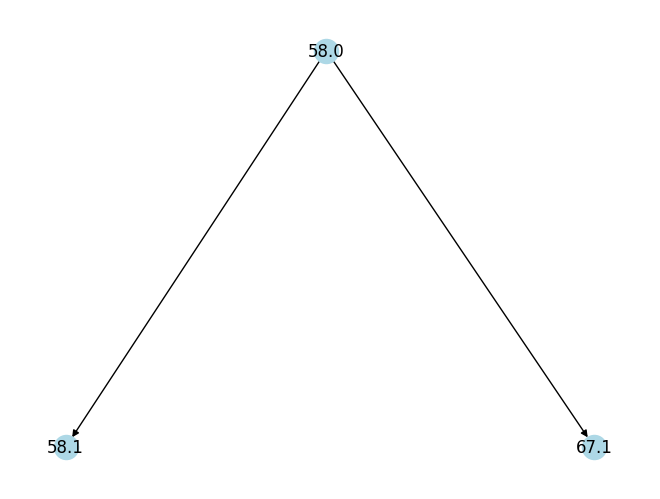

In [83]:
create_cell_ancestry(small.copy())

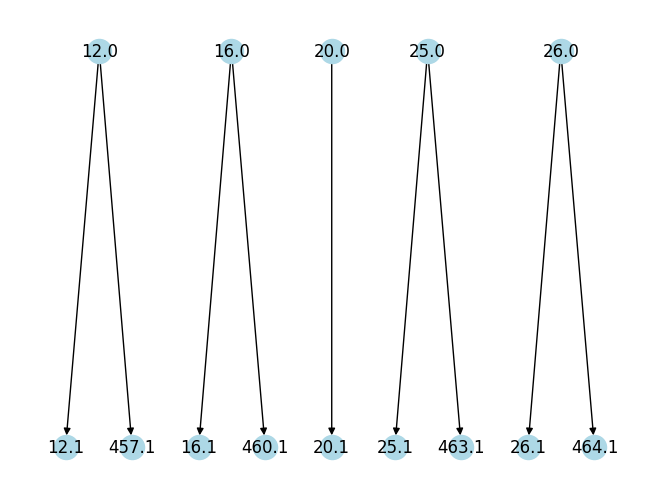

In [85]:
# create_cell_ancestry(large.copy())

# large['ID'] = large.index
# print(large.loc[(large['parent_ID'] == 16.0) | (large['parent_ID'] == 16.1)])

l = df_cell_large.copy()
l = l.loc[(l['parent_ID'] >= 10.0) & (l['parent_ID'] <= 30.0)]

create_cell_ancestry(l)